In [85]:
import requests
import json
import pandas as pd
import time
from dateutil.parser import parse
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from varname import nameof
#필수 함수 정의
apikey = 'X1o3cmgN7nsBDsInu4km3XtlPD051oPC'
wordType = 'matche'
main_url = 'https://api.neople.co.kr/cy/'
player_url = 'https://api.neople.co.kr/cy/players/'
matches_url = 'https://api.neople.co.kr/cy/matches/'
pd.options.display.max_columns = 300
columnsname = ['nickname','characterName','position','attribute1','attribute2','attribute3','hand','hand(rarityName)','head','head(rarityName)','chest','chest(rarityName)','waist','waist(rarityName)','leg','leg(rarityName)','foot','foot(rarityName)','accessories1','accessories1(rarityName)','accessories2','accessories2(rarityName)','recovery','recovery(rarityName)','accelerator','accelerator(rarityName)','attack','attack(rarityName)','defense','defense(rarityName)','special','special(rarityName)','neck','neck(rarityName)','accessories3','accessories3(rarityName)','accessories4','accessories4(rarityName)','random','level','killCount','deathCount','assistCount','attackPoint','damagePoint','battlePoint','sightPoint','getCoin','spendConsumablesCoin','sentinelKillCount','demolisherKillCount','playTime','minLifeTime','maxLifeTime','responseTime','team','matchId','map']


In [84]:
pip install varname

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt#시각화
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [3]:
# 데이터 수집단 함수 정리
def get_playerid(nickname):#플레이어 고유 id를 구하는 함수
    api = main_url+'players?nickname='+nickname+'&wordType='+wordType+'&apikey='+apikey
    playerdata = requests.get(api)
    playerId = playerdata.json()['rows'][0]['playerId']
    return playerId

#매치 id 가져오기
def get_matches(playerId):
    matchids = []
    gameTypeId = 'rating'
    #검색 시작일
    startDate='2022-01-01'
    endDate='2022-03-30'
    limit = 1000
    player_url = 'https://api.neople.co.kr/cy/players/'
    cc = player_url+playerId+'/matches?gameTypeId='+gameTypeId+'&apikey='+apikey+'&startDate='+startDate+'&endDate='+endDate
    playdata = requests.get(cc)
    playdata_info= playdata.json()
    while True:
        try:
            for matche in playdata_info['matches']['rows']:
                matchids.append(matche['matchId'])
            next = playdata_info['matches']['next']
            cc_next = player_url+playerId+'/matches?gameTypeId='+gameTypeId+'&apikey='+apikey+'&startDate='+startDate+'&endDate='+endDate+'&next='+next    
            playdata = requests.get(cc_next)
            playdata_info= playdata.json()
            time.sleep(0.5)
        except:
            break
        
    return matchids


def win_and_lose(matchId):#매치 id를 들고와서 승리팀 조합과,패배팀 조합으로 나눠줌
    api3=matches_url+matchId+'?&apikey='+apikey
    game = requests.get(api3)
    lose_team = []
    win_team = []
    lose_ch = []
    win_ch = []
    try:
        if game.json()['teams'][0]['result'] == 'lose':
            for lose_player in game.json()['teams'][0]['players']:
                lose_team.append(lose_player)
            for win_player in game.json()['teams'][1]['players']:
                win_team.append(win_player)
        elif game.json()['teams'][0]['result'] == 'win':
            for lose_player in game.json()['teams'][1]['players']:
                lose_team.append(lose_player)
            for win_player in game.json()['teams'][0]['players']:
                win_team.append(win_player)
        lose_ch =[]
        win_ch = []
        for i in range(0,10):
            if game.json()['players'][i]['playerId'] in lose_team:
                lose_ch.append(game.json()['players'][i]['playInfo']['characterName'])
            elif game.json()['players'][i]['playerId'] in win_team:
                win_ch.append(game.json()['players'][i]['playInfo']['characterName'])
    except:pass
    return win_ch,lose_ch

#중복매칭 데이터 방지를 위한 데이터 불러오기
def road_antdpData(graed):
    ant_data = []
    antdpData = pd.read_csv('MatcesData/{0}_antdpData.csv'.format(graed))
    #csv를 리스트로 변환
    for v in antdpData['0']:
        ant_data.append(v)
    return ant_data

# 이번에 얻은 데이터를 중복방지 데이터에 기록하며 저장
def antdpData_save(antdpData,now_matcs,graed):
    antdpData.extend(now_matcs)
    antdpData = pd.DataFrame(antdpData)
    antdpData.to_csv('MatcesData/{0}_antdpData.csv'.format(graed),index=False, encoding="utf-8-sig")
    
#닉네임 수집기
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
#range 검색할 페이지 범위 1부터 200전까지
def get_nicknames(graed,start,end):
    names = []
    if start > 0:
        for i in range(start,end):
            rank = requests.get('https://cyphers.nexon.com/cyphers/article/ranking/total/20/{0}'.format(i))
            rank =rank.text
            soup1 = BeautifulSoup(rank,"html.parser")
            a = soup1.find_all(class_='non_list')
            #non_list라는 태그가 존재할경우 반복문을 끝낸다(없는 페이지기 때문)
            if len(a) > 0:
                break
            soup1 = soup1.findAll(target="_blank")
            for i in soup1:
                    names.append(i.text)#.text로 태그부분 제거
        #들어가면 안되는 요소
        trash = ['회사소개','넥슨PC방','오픈 API','']
        #trash부분을 삭제
        names = [i for i in names if i not in trash]
        # 위식가 밑식은 동일하다
        # for i in names:
        #     if i not in trash:
        #         names.append(i)
        pd.DataFrame(names).to_csv('{0}nickname.csv'.format(graed),index=False, encoding="utf-8-sig")
        return names
    else:
        print('start값이 이상합니다.')
        
def road_nicknames(graed):
    names = []
    antdpData = pd.read_csv('{0}nickname.csv'.format(graed),encoding="utf-8-sig")
    #csv를 리스트로 변환
    for v in antdpData['0']:
        names.append(v)
    return names

In [103]:
#데이터 수집 상세단
def ingame_data(matchId):
    api3=matches_url+matchId+'?&apikey='+apikey
    game = requests.get(api3).json()
    basic = pd.DataFrame(columns=columnsname)
    win_ch,lose_ch = win_and_lose(matchId)
    try:
        for i in range(0,10):
            ch = []
            if game['players'][i]['playInfo']['characterName'] in lose_ch:
                ch.append(game['players'][i]['nickname'])
                ch.append(game['players'][i]['playInfo']['characterName'])
                ch.append(game['players'][i]['position']['name'])
                for j in range(0,3):
                    if j == 0:
                        ch.append(game['players'][i]['position']['attribute'][j]['name'])
                    if j == 1:
                        ch.append(game['players'][i]['position']['attribute'][j]['name'])
                    if j == 2:
                        ch.append(game['players'][i]['position']['attribute'][j]['name'])
                for k in range(0,16):
                    ch.append(game['players'][i]['items'][k]['itemName'])
                    ch.append(game['players'][i]['items'][k]['rarityName'])
                ch.append(game['players'][i]['playInfo']['random']) # 랜덤 유무
                ch.append(game['players'][i]['playInfo']['level'])#레벨
                ch.append(game['players'][i]['playInfo']['killCount'])#죽인 횟수
                ch.append(game['players'][i]['playInfo']['deathCount'])#죽은 횟수
                ch.append(game['players'][i]['playInfo']['assistCount'])#어시
                ch.append(game['players'][i]['playInfo']['attackPoint'])#준 데미지
                ch.append(game['players'][i]['playInfo']['damagePoint'])#받은 데미지
                ch.append(game['players'][i]['playInfo']['battlePoint'])#전투점수
                ch.append(game['players'][i]['playInfo']['sightPoint'])#시야점수
                ch.append(game['players'][i]['playInfo']['getCoin'])#흭득 코인
                ch.append(game['players'][i]['playInfo']['spendConsumablesCoin']) # 소모품 코인
                ch.append(game['players'][i]['playInfo']['sentinelKillCount']) # 센티널(중립) 코인
                ch.append(game['players'][i]['playInfo']['demolisherKillCount']) # 철거반 코인
                ch.append(game['players'][i]['playInfo']['playTime'])
                ch.append(game['players'][i]['playInfo']['minLifeTime'])
                ch.append(game['players'][i]['playInfo']['maxLifeTime'])
                ch.append(game['players'][i]['playInfo']['responseTime'])
                ch.append(0)
                ch.append(matchId)
                ch.append(game['map']['name'])
                ch = pd.DataFrame(ch)
                ch = ch.transpose()
                ch.columns = columnsname
                basic = pd.concat([basic,ch])
        for i in range(0,10):
            ch = []
            if game['players'][i]['playInfo']['characterName'] in win_ch:
                ch.append(game['players'][i]['nickname'])
                ch.append(game['players'][i]['playInfo']['characterName'])
                ch.append(game['players'][i]['position']['name'])
                for j in range(0,3):
                    if j == 0:
                        ch.append(game['players'][i]['position']['attribute'][j]['name'])
                    if j == 1:
                        ch.append(game['players'][i]['position']['attribute'][j]['name'])
                    if j == 2:
                        ch.append(game['players'][i]['position']['attribute'][j]['name'])
                for k in range(0,16):
                    ch.append(game['players'][i]['items'][k]['itemName'])
                    ch.append(game['players'][i]['items'][k]['rarityName'])
                ch.append(game['players'][i]['playInfo']['random']) # 랜덤 유무
                ch.append(game['players'][i]['playInfo']['level'])#레벨
                ch.append(game['players'][i]['playInfo']['killCount'])#죽인 횟수
                ch.append(game['players'][i]['playInfo']['deathCount'])#죽은 횟수
                ch.append(game['players'][i]['playInfo']['assistCount'])#어시
                ch.append(game['players'][i]['playInfo']['attackPoint'])#준 데미지
                ch.append(game['players'][i]['playInfo']['damagePoint'])#받은 데미지
                ch.append(game['players'][i]['playInfo']['battlePoint'])#전투점수
                ch.append(game['players'][i]['playInfo']['sightPoint'])#시야점수
                ch.append(game['players'][i]['playInfo']['getCoin'])#흭득 코인
                ch.append(game['players'][i]['playInfo']['spendConsumablesCoin']) # 소모품 코인
                ch.append(game['players'][i]['playInfo']['sentinelKillCount']) # 센티널(중립) 코인
                ch.append(game['players'][i]['playInfo']['demolisherKillCount']) # 철거반 코인
                ch.append(game['players'][i]['playInfo']['playTime'])
                ch.append(game['players'][i]['playInfo']['minLifeTime'])
                ch.append(game['players'][i]['playInfo']['maxLifeTime'])
                ch.append(game['players'][i]['playInfo']['responseTime'])
                ch.append(1)
                ch.append(matchId)
                ch.append(game['map']['name'])
                ch = pd.DataFrame(ch)
                ch = ch.transpose()
                ch.columns = columnsname
                basic = pd.concat([basic,ch])
    except:
        pass
    return basic
#탈주 데이터 제거
def breakout_Removal(game_data):
    value_counts = game_data.matchId.value_counts()
    error_matchs = value_counts[value_counts != 10].index
    error_matchs_id = []
    for a in error_matchs:
        error_matchs_id.append(a)
    #탈주 매칭 아이디를 저장
    now = time.localtime()
    with open('error/{0}_breakout_matchs_id.txt'.format(time.strftime('%y%m%d_%H_%M_%S', now)),'w',encoding='UTF-8') as f:
        for name in error_matchs_id:
            f.write(name+'\n')
    #탈주 매칭 데이터를 바탕으로 제거
    error_index = []
    for error_id in error_matchs_id:
        indexs = game_data[game_data.matchId==error_id].index
        for i in indexs:
             game_data = game_data.drop(i)
    game_data = game_data.reset_index(drop=True)
    return game_data

In [4]:
filename = 'low'
#하위 유저를 크롤링하는 함수 
#크롤링 함수를 사용
users = get_nicknames(filename,99,100)#'저장할이름,시작페이지,종료페이지'
basic = pd.DataFrame(columns=columnsname) #분석할 데이터프레임 생성
# 크롤링한 아이디를 바탕으로 매칭id를 불러옴
users_matcs = []
for nickname in users:
    playerId = get_playerid(nickname)
    matchids = get_matches(playerId)
    antdpData = road_antdpData(filename)
    now_matcs = []
    for v in matchids:
        if v not in antdpData:
            now_matcs.append(v)
            users_matcs.append(v)
    antdpData_save(antdpData,now_matcs,filename)
#불러온 매칭id를 바탕으로 게임속 데이터를 csv로 저장
for matchId in users_matcs: #
    b = ingame_data(matchId)
    basic = pd.concat([basic,b])
    time.sleep(0.3)
    basic = basic.reset_index(drop=True)
    basic.to_csv('gamedata/{}.csv'.format(name),index=False, encoding="utf-8-sig")#저장이름 설정

KeyboardInterrupt: 

In [115]:
lowuser = pd.read_csv('gamedata/low.csv')
topuser = pd.read_csv('gamedata/top.csv')

In [106]:
lowuser

,nickname,characterName,position,attribute1,attribute2,attribute3,hand,hand(rarityName),head,head(rarityName),chest,chest(rarityName),waist,waist(rarityName),leg,leg(rarityName),foot,foot(rarityName),accessories1,accessories1(rarityName),accessories2,accessories2(rarityName),recovery,recovery(rarityName),accelerator,accelerator(rarityName),attack,attack(rarityName),defense,defense(rarityName),special,special(rarityName),neck,neck(rarityName),accessories3,accessories3(rarityName),accessories4,accessories4(rarityName),random,level,killCount,deathCount,assistCount,attackPoint,damagePoint,battlePoint,sightPoint,getCoin,spendConsumablesCoin,sentinelKillCount,demolisherKillCount,playTime,minLifeTime,maxLifeTime,responseTime,team,matchId,map
0,번개아저씨,휴톤,탱커,전투 태세,재생의 숨결,최후의 저항,E 블래스터 비트,유니크,S 해일매리 패스,유니크,S 터스킨,유니크,S 데모닉 펀쳐,유니크,E 스톤 크래셔,유니크,S 아이언 룰러,유니크,지옥구멍 레그람,레어,바야바 아몬,레어,본 스파클링,레어,런업 스프린터,레어,아이리쉬 이펙트,레어,아이리쉬 타즈,레어,드래곤 플라이R,커먼,S 브레이킹 스매쉬,유니크,서든어퍼 레그람,레어,누크 퓨리피스트,유니크,False,41,5,8,5,26622,64656,212,306,15100,6100,15,6,1346,23,326,295,0,6a772def07104993711082b7495a29939c6a4798033969...,그랑플람 아시아 지부
1,진집사,엘프리데,원거리딜러,완벽주의자,사냥꾼의 본능,전장의 열기,E 결정적 순간,유니크,S 감춰진 시선,유니크,S 오버 필링,유니크,E 레스트레인트,유니크,S 완벽한 자유,유니크,S 온화한 발걸음,유니크,팰리스 메모,레어,저스티스 페인트북,레어,체스터 더블버거,레어,페이트 스프린터,레어,이펙트 이펙션,레어,솔리드 스위퍼,레어,타나토스 맥시머,레어,E 잔혹한 처벌,유니크,데블스 페인트북,레어,정해진 운명,유니크,False,67,6,3,9,53877,15239,114,140,21200,2600,29,33,1346,153,680,130,0,6a772def07104993711082b7495a29939c6a4798033969...,그랑플람 아시아 지부
2,미안해내가좀잘해,하랑,원거리딜러,충동 구매,할인 판매,준비된 한 발,E 호기만장,유니크,E 마파람,유니크,E 칠전팔기,유니크,E 가온누리,유니크,E 높새구름,유니크,E 천우신조,유니크,벽조목-자령,레어,제압 명주고리,레어,체스터 더블버거,레어,런업 스프린터,레어,이펙트 이펙션,레어,영력 타즈,레어,괴력난신 맥시머,레어,E 사나운 패기,유니크,술령 명주고리,레어,호아호신부,유니크,False,66,3,6,7,37852,27323,130,141,20380,2940,24,37,1346,72,363,222,0,6a772def07104993711082b7495a29939c6a4798033969...,그랑플람 아시아 지부
3,dpswhdl,루이스,근거리딜러,급소 가격,사냥꾼의 본능,거인 사냥꾼,E 아이스 에이지,유니크,S 윈터 크루제이드,유니크,S 프로즌 시티,유니크,E 아이스 토퀴즈,유니크,E 절대영도,유니크,S 크리스탈 크랙,유니크,빙산 프로프링,레어,리볼버 유노,레어,체스터 버거,언커먼,아이스 스프린터,레어,아이스 파이크,레어,아이스 타즈,레어,영구동토 맥시머,레어,E 프로즌 하트,유니크,드라이 파이몬,레어,프로즌 브레이크,유니크,False,60,7,5,2,27995,18582,53,83,20860,4700,23,32,1346,38,500,194,0,6a772def07104993711082b7495a29939c6a4798033969...,그랑플람 아시아 지부
4,번개아저씨,휴톤,탱커,전투 태세,재생의 숨결,최후의 저항,E 블래스터 비트,유니크,S 해일매리 패스,유니크,S 터스킨,유니크,S 데모닉 펀쳐,유니크,E 스톤 크래셔,유니크,S 아이언 룰러,유니크,지옥구멍 레그람,레어,바야바 아몬,레어,본 스파클링,레어,런업 스프린터,레어,아이리쉬 이펙트,레어,아이리쉬 타즈,레어,드래곤 플라이R,커먼,S 브레이킹 스매쉬,유니크,서든어퍼 레그람,레어,누크 퓨리피스트,유니크,False,47,3,7,12,28564,58210,278,413,15440,4800,16,5,1347,34,247,249,0,45b361015d618d6378d19948eb1062d0b8cdb6bd24be42...,메트로폴리스
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19977,르시,윌라드,원거리딜러,완벽주의자,사냥꾼의 본능,전장의 열기,E 일렉트론 토쳐,유니크,E 그랜드 듀크,유니크,E 블레스트 슈트,유니크,E 청천벽력,유니크,E 스틸레토라,유니크,E 라이트 블리츠,유니크,낙뢰 라이픈 E,언커먼,구형 루드크리스,레어,체스터 더블버거,레어,라이트닝 스프린터,레어,멜츠 크리민II,언커먼,라이트닝 플래쉬,레어,T2 통신기,언커먼,E 블리츠 와일즈,유니크,체인 볼트스토퍼,레어,썬더 고르드마스,유니크,False,45,3,13,8,19335,47287,204,197,14840,3200,16,13,1201,32,129,421,0,84c3b579d4ae39ab86d63ec91d27efdccf08bfd4bd0896...,스프링필드
19978,크리스탈클라우드,휴톤,탱커,불굴의 의지,재생의 숨결,최후의 저항,E 블래스터 비트,유니크,E 해일매리 패스,유니크,E 터스킨,유니크,RA골든파워 버클,레어,E 스톤 크래셔,유니크,E 아이언 룰러,유니크,파워체인-가드,레어,바야바 바쿠스,레어,본 스파클링,레어,런업 스프린터,레어,넬스 크리민S,언커먼,닷지 실피드,레어,PS 레이더 R4,언커먼,E 브레이킹 스매쉬,유니크,서든어퍼 레그람,레어,누크 퓨리피스트,유니크,False,48,10,10,11,36898,61295,319,402,15680,4000,8,3,1201,32,175,301,0,84c3b579d4ae39ab86d63ec91d27efdccf08bfd4bd0896...,스프링필드
19979,응애ㅇㅅㅇ,미아,원거리딜러,완벽주의자,사냥꾼의 본능,전장의 열기,E 이볼브 가이아,유니크,E 디바인 그레이스,유니크,S 옐로우 루트웨이브,유니크,S 프릭클 에린,유니크,E 와일드 크로스,유니크,E 이네이쳐 게브,유니크,도장 바이리프,레어,가시 바이리프,레어,체스터 더블버거,레어,우드 엑셀,레어,이펙트 이펙션,레어,스테민 터틀,레어,세계수 맥시머,레어,S 레드 크로니클,유니크,뿌리 바이리프,레어,트리콜로 트와인,유니크,False,54,14,9,15,65047,38805,175,237,19280,5300,12,17,1201,17,446,291,0,84c3b579d4ae39ab86d63ec91d27efdccf08bfd4bd0896...,스프링필드
19980,생태,벨져,탱커,불굴의 의지,재생의 숨결,최후의 저항,E 쉬레 슈나이더,유니크,E 그레이 데스티니,유니크,E 예니체리,유니크,E 에보니 샤르페,유니크,E 님블 사브르,유니크,E 크레시에 슈트름,유니크,제야

In [117]:
topuser.matchId.value_counts()

f9fa9cd7fd0fe943b6e67ab6d67fe914cf7afdff5267bb8f91e566513829a495    10
7493b3f5a5a12e61252645f00c3aff1e1e8b0e6ae1479e27d20f6c23c6a96551    10
9f327b872b9590962f44253a33fbef525833a8c071015cf99a5479e378d05643    10
346d0285da4ec38070d0b69f64f071afc480f247ca03ff93430721670f60e80a    10
02a9053deffab6e778ce1ed481502f1bc5625784f70edd613d96658d18c475bc    10
                                                                    ..
5d009f09cacf54392954ad1e8c879683f8662f874f19c67582479af47a64d0d3     1
4b55b5bae01bd83072749e3f1cc18d7b2cc7d66114afe1dbec64d7ce3ec41bda     1
cf9cee290289c9ee39b40f06e84aae0cfb4bc1a024ee0694c91e83d6f3d961df     1
ae0822d8be3a4d237c7a99c262b1996754713ff33ae849f6e4f282637ac86645     1
7bad8d8c35d7d62b7caa462e45bcaf73dd00a09ce66f3f786ff6209d35b72e51     1
Name: matchId, Length: 2086, dtype: int64

In [111]:
topuser.describe()

,level,killCount,deathCount,assistCount,attackPoint,damagePoint,battlePoint,sightPoint,getCoin,spendConsumablesCoin,sentinelKillCount,demolisherKillCount,playTime,minLifeTime,maxLifeTime,responseTime,team
count,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000,13370.000000
mean,45.563426,4.369110,4.416006,9.279656,26152.115856,26138.897831,168.076889,238.748093,14747.454375,3007.015707,18.189903,17.981077,960.605236,102.959985,397.888706,125.419820,0.500000
std,11.492597,3.974368,2.488603,5.829049,16178.388225,13294.064858,75.892763,104.746598,4040.612498,1166.230849,10.313461,13.179538,199.199101,165.130233,194.981256,75.206556,0.500019
min,14.000000,0.000000,0.000000,0.000000,34.000000,0.000000,0.000000,5.000000,5070.000000,0.000000,0.000000,0.000000,133.000000,0.000000,47.000000,0.000000,0.000000
25%,36.000000,1.000000,3.000000,5.000000,12869.750000,16336.000000,110.000000,157.000000,11592.500000,2200.000000,10.000000,6.000000,815.000000,28.000000,252.000000,69.000000,0.000000
50%,45.000000,3.000000,4.000000,9.000000,22971.500000,23748.000000,158.000000,220.000000,14330.000000,2900.000000,17.000000,17.000000,935.500000,48.000000,360.000000,121.000000,0.500000
75%,55.000000,7.000000,6.000000,12.000000,36554.500000,34267.000000,215.000000,306.750000,17690.000000,3700.000000,25.000000,27.000000,1097.000000,97.000000,503.000000,173.000000,1.000000
max,68.000000,28.000000,18.000000,51.000000,120644.000000,99439.000000,569.000000,786.000000,29590.000000,9900.000000,67.000000,77.000000,1606.000000,1603.000000,1603.000000,575.000000,1.000000


In [118]:
topuser=breakout_Removal(topuser)
lowuser=breakout_Removal(lowuser)

In [119]:
topuser

,nickname,characterName,position,attribute1,attribute2,attribute3,hand,hand(rarityName),head,head(rarityName),chest,chest(rarityName),waist,waist(rarityName),leg,leg(rarityName),foot,foot(rarityName),accessories1,accessories1(rarityName),accessories2,accessories2(rarityName),recovery,recovery(rarityName),accelerator,accelerator(rarityName),attack,attack(rarityName),defense,defense(rarityName),special,special(rarityName),neck,neck(rarityName),accessories3,accessories3(rarityName),accessories4,accessories4(rarityName),random,level,killCount,deathCount,assistCount,attackPoint,damagePoint,battlePoint,sightPoint,getCoin,spendConsumablesCoin,sentinelKillCount,demolisherKillCount,playTime,minLifeTime,maxLifeTime,responseTime,team,matchId,map
0,최두나,제이,탱커,전투 태세,할인 판매,최후의 저항,E 패스티스트 건,유니크,E 퍼니시먼트,유니크,E 헤븐즈 도어,유니크,E 트러블 메이커,유니크,E 데스페라도,유니크,S 퀵 앤 데드,유니크,SB스프리건 루인,레어,니들 터퀴즈,레어,퍼니시 스파클링,레어,런업 스프린터,레어,퍼니시 파이크,레어,솔리드 스위퍼,레어,PS 레이더 R4,언커먼,E 멕시칸 불독,유니크,난사 레그람,레어,타임투킬 레그람,레어,False,48,2,6,18,24769,39299,193,292,15370,3510,16,11,1076,58,305,174,0,f9fa9cd7fd0fe943b6e67ab6d67fe914cf7afdff5267bb...,메트로폴리스
1,도도코대마왕,엘프리데,원거리딜러,충동 구매,할인 판매,준비된 한 발,E 결정적 순간,유니크,S 감춰진 시선,유니크,E 오버 필링,유니크,E 레스트레인트,유니크,S 완벽한 자유,유니크,S 온화한 발걸음,유니크,팰리스 메모,레어,저스티스 페인트북,레어,체스터 더블버거,레어,페이트 엑셀,레어,페이트 파이크,레어,솔리드 스위퍼,레어,타나토스 맥시머,레어,E 잔혹한 처벌,유니크,SB데블스 데브,레어,정해진 운명,유니크,False,52,3,7,12,43365,21944,131,158,16770,2730,17,16,1076,25,304,237,0,f9fa9cd7fd0fe943b6e67ab6d67fe914cf7afdff5267bb...,메트로폴리스
2,참지않는사람,이글,탱커,전투 태세,할인 판매,최후의 저항,E 브리닝 슈나이더,유니크,E 스크라이 쇼크,유니크,S 언밸런스 레퀴엠,유니크,E 화이트 샤르페,유니크,S 킬 블레이드,유니크,E 바이스 슈트름,유니크,장작 레그람,레어,사영 레그람,레어,첼시 콜라 MAX,레어,리세스 스프린터,레어,스네이크 파이크,레어,솔리드 스위퍼,레어,PS 레이더 R4,언커먼,E 스네이크 오빗,유니크,초승달 셀레네,레어,쉬베르트 바이스,유니크,False,61,7,6,10,41002,33870,242,281,18450,3620,47,16,1076,39,267,206,0,f9fa9cd7fd0fe943b6e67ab6d67fe914cf7afdff5267bb...,메트로폴리스
3,배달요원,미아,원거리딜러,완벽주의자,전장의 학살자,완전한 성장,E 이볼브 가이아,유니크,E 디바인 그레이스,유니크,E 옐로우 루트웨이브,유니크,E 프릭클 에린,유니크,E 와일드 크로스,유니크,E 이네이쳐 게브,유니크,도장 바이리프,레어,가시 바이리프,레어,체스터 더블버거,레어,런업 스프린터,레어,우드 파이크,레어,솔리드 스위퍼,레어,세계수 맥시머,레어,S 레드 크로니클,유니크,뿌리 바이리프,레어,트리콜로 트와인,유니크,False,48,3,9,8,17360,27630,124,167,15610,3300,15,17,1076,10,266,276,0,f9fa9cd7fd0fe943b6e67ab6d67fe914cf7afdff5267bb...,메트로폴리스
4,용1현,티모시,탱커,최후의 저항,충동 구매,전투 태세,DB애쉬 마노,레어,S 이너 스트랭스,유니크,E 레클러메이션,유니크,E 뉴 비기닝,유니크,S 오소틱,유니크,S 내딛은 걸음,유니크,번 버스터 레그람,레어,잿불 레그람,레어,애쉬 스파클링,레어,런업 스프린터,레어,애쉬 파이크,레어,애쉬 타즈,레어,PS 레이더 R4,언커먼,S 달콤한 죄책감,유니크,화염포 레그람,레어,라스트 릭,유니크,False,40,6,7,5,30869,38027,240,328,14670,5200,5,3,1076,37,300,135,0,f9fa9cd7fd0fe943b6e67ab6d67fe914cf7afdff5267bb...,메트로폴리스
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13365,케니스원툴,티모시,탱커,최후의 저항,낙법,불굴의 의지,E 덱스트러스,유니크,S 이너 스트랭스,유니크,E 레클러메이션,유니크,E 뉴 비기닝,유니크,S 오소틱,유니크,S 내딛은 걸음,유니크,번 버스터 레그람,레어,잿불 레그람,레어,애쉬 스파클링,레어,런업 스프린터,레어,애쉬 파이크,레어,애쉬 플래쉬,레어,인사이트 엔진T7,언커먼,도전의 로사리오,레어,화염포 펜슬,레어,라스트 릭,유니크,False,41,7,5,16,25114,45088,322,432,16000,5000,19,3,1260,45,474,102,1,7e5c628d939498bc3ee75fb96026f9aef96197ce71da93...,메트로폴리스
13366,쫄라맨,마틴,서포터,활성화 지원,신경쇠약,부서진 갑옷,E 마스터 마인드,유니크,사이트 인베스트,레어,S 루브르 디텍터,유니크,S 메즈메리즘,유니크,E 솔로스 인듀서,유니크,E 데인저러스 플롯,유니크,파이널 레그람,레어,힙노시스 스팟,레어,첼시 콜라 MAX,레어,런업 스프린터,레어,마인드 이펙트,레어,솔리드 스위퍼,레어,최면 임팩트,언커먼,E 힙노티스트,유니크,마리오넷 레그람,레어,사일런트 레그람,레어,False,56,2,4,25,27715,23355,346,563,16980,4400,10,12,1260,106,495,102,1,7e5c628d939498bc3ee75fb96026f9aef96197ce71da93...,메트로폴리스
13367,신라면순한맛,휴톤,탱커,전투 태세,단단한 피부,최후의 저항,SP혼신의 일격,레어,테너서티 컨트롤,레어,DB본 헤르츠,레어,SP플래티넘 체인,레어,SP풋워크 트릭,레어,FA락포트 버스터,레어,지옥구멍 레그람,레어,바야바 레그람,레어,본 스파클링,레어,런업 스프린터,레어,아이리쉬 이펙트,레어,아이리쉬 플래쉬,레어,인사이트 엔진T7,언커먼,플래티넘 체인,레어,서든어퍼 레그람,레어,누크 퓨리피스트,유니크,False,56,4,6,17,27126,35166,295,433,15740,3000,10,8,1260,45,493,131,1,7e5c628d939498bc3ee75fb96026f9aef96197ce71da93...,메트로폴리스
13368,서해준,엘프리데,원거리딜러,재장전,전장의 학살자,전장의 열기,시크 브레이슬릿,레어,S 감춰진 시선,유니크,E 오버 필링,유니크,E 레스트레인트,유니크,S 완벽한 자유,유니크,S 온화한 발걸음,유니크,팰리스 메모,레어,저스티스 페인트북,레어,체스터 더블버거,레어,엑셀레이션,레어,이펙

In [120]:
lowuser

,nickname,characterName,position,attribute1,attribute2,attribute3,hand,hand(rarityName),head,head(rarityName),chest,chest(rarityName),waist,waist(rarityName),leg,leg(rarityName),foot,foot(rarityName),accessories1,accessories1(rarityName),accessories2,accessories2(rarityName),recovery,recovery(rarityName),accelerator,accelerator(rarityName),attack,attack(rarityName),defense,defense(rarityName),special,special(rarityName),neck,neck(rarityName),accessories3,accessories3(rarityName),accessories4,accessories4(rarityName),random,level,killCount,deathCount,assistCount,attackPoint,damagePoint,battlePoint,sightPoint,getCoin,spendConsumablesCoin,sentinelKillCount,demolisherKillCount,playTime,minLifeTime,maxLifeTime,responseTime,team,matchId,map
0,너희한테실망했다,이글,근거리딜러,추격자의 발걸음,사냥꾼의 본능,거인 사냥꾼,E 브리닝 슈나이더,유니크,S 스크라이 쇼크,유니크,E 언밸런스 레퀴엠,유니크,E 화이트 샤르페,유니크,E 킬 블레이드,유니크,E 바이스 슈트름,유니크,장작 엘리고스,레어,SB뱀그림자 루차,레어,체스터 더블버거,레어,리세스 스프린터,레어,스네이크 파이크,레어,스네이크 타즈,레어,하드스킨 크래셔,레어,E 라이언트 소드,유니크,SB초승달 데브,레어,쉬베르트 바이스,유니크,False,41,1,7,4,20497,25945,72,119,12950,2500,20,22,888,9,186,184,0,0d125b35ac3be1302a8b5c24f9bc631880bafe573227e9...,메트로폴리스
1,번개아저씨,휴톤,탱커,전투 태세,재생의 숨결,최후의 저항,E 블래스터 비트,유니크,S 해일매리 패스,유니크,S 터스킨,유니크,S 데모닉 펀쳐,유니크,E 스톤 크래셔,유니크,S 아이언 룰러,유니크,지옥구멍 레그람,레어,바야바 아몬,레어,본 스파클링,레어,런업 스프린터,레어,아이리쉬 이펙트,레어,아이리쉬 타즈,레어,드래곤 플라이R,커먼,S 브레이킹 스매쉬,유니크,서든어퍼 레그람,레어,누크 퓨리피스트,유니크,False,31,2,6,3,16922,29411,188,255,9910,2900,11,4,888,10,291,127,0,0d125b35ac3be1302a8b5c24f9bc631880bafe573227e9...,메트로폴리스
2,참교육으로가는길,다이무스,탱커,최후의 저항,재생의 숨결,전선 유지,E 메이헨 슈나이더,유니크,S 베스페리아,유니크,S 우아한 궤적,유니크,E 골드 샤르페,유니크,EP이터널 소드,레어,E 슈발츠 슈트름,유니크,장작 라이픈 C,언커먼,질풍의 레그람,레어,액트 스파클링,레어,질풍의 스프린터,레어,질풍의 파이크,레어,하디스트 스위퍼,레어,절명도 맥시머,레어,S 냉정한 카리스마,유니크,보름달 레그람,레어,쉬베르트 루프리,유니크,False,28,4,8,6,25969,43154,234,304,10650,4000,1,4,888,19,194,193,0,0d125b35ac3be1302a8b5c24f9bc631880bafe573227e9...,메트로폴리스
3,도그놈,루시,원거리딜러,완벽주의자,사냥꾼의 본능,전장의 열기,E 섬섬옥수,유니크,E 오발선빈,유니크,E 지체투향,유니크,S 세류요,유니크,E 작장중무,유니크,E 연보소말,유니크,낙화 청옥석,레어,반월 청옥석,레어,체스터 더블버거,레어,송편,레어,파이크 이펙션,레어,스테민 터틀,레어,반월 임팩트,언커먼,E 적월선,유니크,화무십일홍 결의,레어,절세가인,유니크,False,38,5,6,4,20558,25795,114,196,12150,1700,15,11,888,13,203,171,0,0d125b35ac3be1302a8b5c24f9bc631880bafe573227e9...,메트로폴리스
4,계영,파수꾼 A,원거리딜러,충동 구매,할인 판매,완벽주의자,E 어센던트,유니크,S 피어싱 아이즈,유니크,S 무형의 감옥,유니크,E 짜여진 각본,유니크,S 하빈저,유니크,E 에고이스트,유니크,클로 에델슈타인,레어,크로우 편지함,레어,체스터 더블버거,레어,레이븐 스프린터,레어,파이크 이펙션,레어,레이븐 타즈,레어,워든 맥시머,레어,E 잔혹한 모략가,유니크,SB시프트 데브,레어,그라시아 에피칵스,유니크,False,49,5,6,7,30497,23902,193,198,14290,1590,18,25,888,16,170,192,0,0d125b35ac3be1302a8b5c24f9bc631880bafe573227e9...,메트로폴리스
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12245,크리스탈클라우드,린,탱커,불굴의 의지,재생의 숨결,최후의 저항,E 모란꽃 손매듭,유니크,E 일곱빛깔 무지개,유니크,E 금선당 당의,유니크,E 오색칠보 노리개,유니크,E 천년의 기억,유니크,E 당혜,유니크,염동파 라이픈 C,언커먼,참나무 혜원,레어,첼시 콜라 V,레어,런업 스프린터,레어,염동 파이크,레어,염동 타즈,레어,DT 인사이트 R1,커먼,E 단아한 미소,유니크,무쇠가위 레그람,레어,은협도,유니크,False,39,3,7,18,10045,42505,287,387,12010,2400,6,1,868,48,299,126,1,6928b95cf4e104d254d94989c1e3ed68aa905bd2e164d8...,리버포드
12246,바람의싸움꾼,타라,원거리딜러,완벽주의자,사냥꾼의 본능,전장의 열기,E 데몰리션 파이어,유니크,E 아이리스 보터,유니크,E 마녀의 유희,유니크,E 무크 디토네이터,유니크,E 스칼렛 랩소디,유니크,E 파이어 포르테,유니크,불놀이 하우레스,레어,발화 하우레스,레어,토치 스파클링,레어,스피드 업,커먼,플레어 이펙트,레어,베링거 터틀본,언커먼,공간발화 임팩트,언커먼,E 스티즈 머쉬,유니크,정념 하우레스,레어,메테오 카티에르,유니크,False,51,10,5,14,45391,21886,137,151,15910,2400,14,18,868,74,284,116,1,6928b95cf4e104d254d94989c1e3ed68aa905bd2e164d8...,리버포드
12247,응애ㅇㅅㅇ,트리비아,원거리딜러,완벽주의자,충동 구매,전장의 열기,S 미스틱 포그,유니크,E 블러드 카니발,유니크,E 트리니티 블러드,유니크,S 블랙버드 블러섬,유니크,S 그림자 자국,유니크,E 포르미체티,유니크,밤의여왕-변이,레어,SB부츠커터 루차,레어,체스터 더블버거,레어,리세스 스프린터,레어,배트 파이크,레어,스테민 터틀,레어,박쥐폭풍 임팩트,언커먼,S 엘루어 배트,유니크,박쥐폭풍 보티스,레어,시엘 루드플리가,유니크,False,44,6,6,8,21822,18451,80,149,15050,4000,14,17,868,15,327,159,1,6928b95cf4e104d254d94989c1e3ed68aa905bd2e164d8...,리버포드
12248,이게임정말재밌다,제이,근거리딜러,속전속결,사냥꾼의 본능,거인 사냥꾼,E 패스티스트 건,유니크,E 퍼니시먼트,유니크,E 헤븐즈 도어,유니크,E 트러블 메이커,유니크,E 데스페라도,유니크,E 퀵 앤 데드,유니크,스프리건 더블건,레어,니들 옵시디언,레어,체스터 더블버거,레어,리

In [7]:
topuser[topuser.team == 1].characterName.value_counts()

아이작     268
론       268
엘프리데    229
드렉슬러    211
플로리안    187
       ... 
샬럿       37
클리브      26
탄야       24
미쉘       21
빅터        8
Name: characterName, Length: 73, dtype: int64

In [9]:
topuser[topuser.team == 0].characterName.value_counts()

엘프리데    246
아이작     211
드렉슬러    203
론       203
휴톤      189
       ... 
히카르도     34
탄야       28
클리브      26
미쉘       19
빅터        8
Name: characterName, Length: 73, dtype: int64

In [179]:
topuser.to_csv('FinalData/topuser.csv',index=False, encoding="utf-8-sig")

In [18]:
lowuser.to_csv('FinalData/lowuser.csv',index=False, encoding="utf-8-sig")

In [27]:
topuser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13370 entries, 0 to 13369
Data columns (total 58 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   nickname                  13350 non-null  object
 1   characterName             13370 non-null  object
 2   position                  13370 non-null  object
 3   attribute1                13370 non-null  object
 4   attribute2                13370 non-null  object
 5   attribute3                13370 non-null  object
 6   hand                      13370 non-null  object
 7   hand(rarityName)          13370 non-null  object
 8   head                      13370 non-null  object
 9   head(rarityName)          13370 non-null  object
 10  chest                     13370 non-null  object
 11  chest(rarityName)         13370 non-null  object
 12  waist                     13370 non-null  object
 13  waist(rarityName)         13370 non-null  object
 14  leg                   

In [73]:
train = topuser[['attackPoint','team','deathCount','killCount','position','damagePoint','level','getCoin','responseTime','sightPoint','sentinelKillCount','spendConsumablesCoin','maxLifeTime']]
le_encoding = LabelEncoder()
encoded = le_encoding.fit(train_corr['position'])
train_corr['position'] = encoded.transform(train_corr['position'])

C:\ProgramData\Anaconda3\envs\bigdata0809\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [76]:
train.position.value_counts()

2    6759
3    6619
0    2795
1     844
Name: position, dtype: int64

In [78]:
topuser.position.value_counts()

2    6759
3    6619
0    2795
1     844
Name: position, dtype: int64

In [62]:
train_corr = train
scaler= MinMaxScaler() 
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

C:\ProgramData\Anaconda3\envs\bigdata0809\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Text(0.5, 1.0, 'Correlation between features')

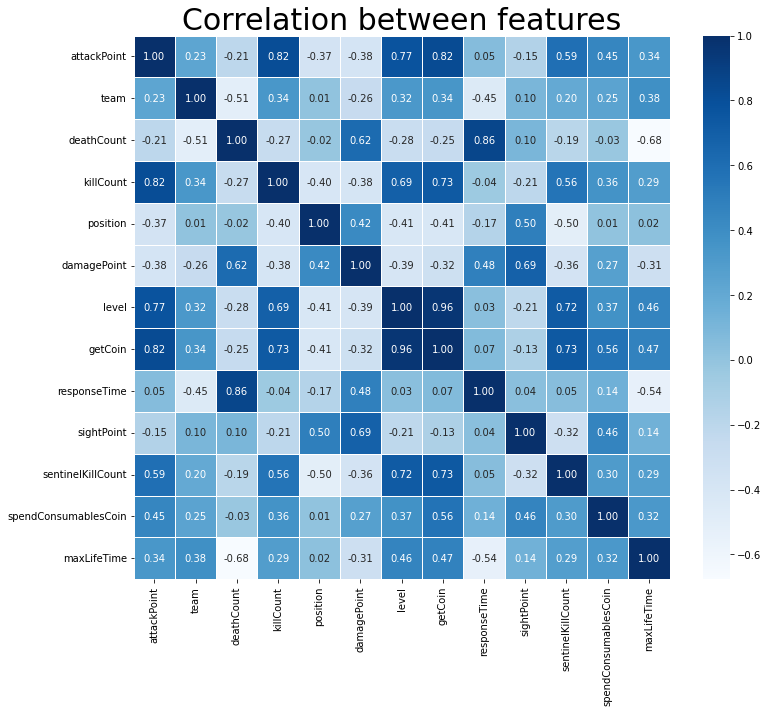

In [63]:
plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

In [64]:
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['team'].sort_values(ascending=False), columns=['team'])
df_temp28.style.background_gradient(cmap='viridis')

,team
team,1.000000
maxLifeTime,0.382821
getCoin,0.339601
killCount,0.336763
level,0.324066
spendConsumablesCoin,0.246123
attackPoint,0.228847
sentinelKillCount,0.199274
sightPoint,0.101743
position,0.007707


In [133]:
topuser[topuser.characterName==17].special.value_counts()

리볼버 임팩트       150
하드스킨 버스터       66
하드스킨 크래셔       15
인사이트 엔진T7       7
영구동토 맥시머        4
PS 레이더 R4       3
DT 인사이트 R1      2
Name: special, dtype: int64

In [148]:
topuser[(topuser.characterName==17)&(topuser.special == '하드스킨 버스터')].team.value_counts()

0    34
1    32
Name: team, dtype: int64

In [149]:
topuser[(topuser.characterName==17)&(topuser.special == '하드스킨 크래셔')].team.value_counts()

1    11
0     4
Name: team, dtype: int64

In [161]:
topuser[(topuser.characterName==17)&(topuser.special == '하드스킨 크래셔')].team.value_counts()

1    4
0    3
Name: team, dtype: int64

In [158]:
lowuser[(lowuser.characterName=='루이스')&(lowuser.special == '하드스킨 버스터')].team.value_counts()

1    53
0    52
Name: team, dtype: int64

In [169]:
lowuser[(lowuser.characterName=='론')&(lowuser.position=='탱커')].team.value_counts()

1    6
0    4
Name: team, dtype: int64

In [168]:
lowuser[(lowuser.characterName=='론')&(lowuser.position=='원거리딜러')].team.value_counts()

1    102
0     77
Name: team, dtype: int64

In [185]:
topuser[(topuser.characterName=='릭')&(topuser.position=='탱커')].team.value_counts()

1    32
0    19
Name: team, dtype: int64

In [186]:
topuser[(topuser.characterName=='릭')&(topuser.position=='원거리딜러')].team.value_counts()

0    15
1     7
Name: team, dtype: int64

In [187]:
topuser[(topuser.characterName=='릭')&(topuser.position=='서포터')].team.value_counts()

0    26
1    26
Name: team, dtype: int64